In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.datasets import make_classification

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
def plot_data(X,y):
    n=np.random.randint(1,778)
    plt.figure(figsize=(16,2))
    for i in range(n,n+8):
        plt.subplot(1,8,i-n+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.binary)
        plt.xlabel(y[i])

In [3]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000,num_node=[20,1],accuracy=0.00001):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.num_layer=len(num_node)
        self.num_node=num_node
        self.accuracy=accuracy
        self.W=None
        self.b=None
        self.Z=None
        self.A=None
        self.dW=None
        self.db=None
        self.dZ=None
        self.dA=None
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = X/255.0
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x):
        self.W=[]
        self.W.append(list(np.random.randn(self.num_node[0], n_x) * 0.01))
        self.b=[np.zeros((self.num_node[i], 1))+0.01 for i in range(self.num_layer)]
        self.W=self.W+[list((np.random.randn(self.num_node[i],self.num_node[i-1])*  0.01)) for i in range(1,self.num_layer)]
        
        

       
    def __forward_propagation(self, X):
        self.Z=[]
        self.A=[]
        self.Z.append(np.dot(self.W[0], X) + self.b[0])
#         print(np.dot(np.ones((1,784)),X))
#         print([(np.isnan(j)==True for j in elem) for elem in np.dot(self.W[0], X)].count(True))
        self.A.append(self.__sigmoid(self.Z[0]))
        for i in range(1,len(self.W)):
            self.Z.append(np.dot(self.W[i], self.A[i-1]) + self.b[i])
            self.A.append(self.__sigmoid(self.Z[i]))
        return self.A[-1]
    
    def compute_cost(self, A, Y):
#         m = len(Y)
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y):
        m = X.shape[1]
        n = X.shape[0]
        W, b,Z, A=self.W,self.b,self.Z,self.A
        self.dW,self.db,self.dZ,self.dA=[],[],[],[]

        self.dZ.append(A[-1] - Y)
        self.dW.append(1. / m * np.dot(self.dZ[-1], A[-2].T))
        self.db.append(1. / m * np.sum(self.dZ[-1], axis = 1, keepdims = True))
        self.dA.append(np.dot(np.array(W[-1]).T, self.dZ[-1]))       


        for i in range(self.num_layer-1):
#             if(self.num_layer-2-i<0):break
            self.dZ.append(np.multiply(self.dA[i], np.multiply(A[self.num_layer-2-i], 1 - A[self.num_layer-2-i])))
            if(self.num_layer-3-i>=0):
                self.dW.append( 1. / m * np.dot(self.dZ[i+1], A[self.num_layer-3-i].T))
            else:
                self.dW.append( 1. / m * np.dot(self.dZ[i+1], X.T))
            self.db.append( 1. / m * np.sum(self.dZ[i+1], axis = 1, keepdims = True))
            self.dA.append(np.dot(np.array(W[self.num_layer-2-i]).T, self.dZ[i+1]))
       
        self.dW.reverse()
        self.db.reverse()
        self.dZ.reverse()
        self.dA.reverse()

    
    def __update_parameters(self):
        
        for i in range(self.num_layer):
            self.W[i] = self.W[i] - self.learning_rate * self.dW[i]
            self.b[i] = self.b[i] - self.learning_rate * self.db[i]

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
#         print(X)

        costs = []
        check = []
        m = X.shape[1]
        n_x = X.shape[0]
        
        
        
        self.__initialize_parameters(n_x)
       
 
        for i in range(self.num_iter):
            A = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            self.__backward_propagation(X, Y)

            self.__update_parameters()
        
            check.append(cost)
            if print_cost and i % 10 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 10 == 0:
                costs.append(cost)
                
            if(len(check)>2 and abs(check[i]-check[i-1])<self.accuracy):
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)   

In [4]:
df = pd.read_csv('train_digits.csv', delimiter=',')
df.describe(include='all')

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [5]:
y=df["label"].values
# y=df["label"].loc[(df["label"]<2)].values
# tmp=df.loc[(df["label"]<2)]
# X=tmp.iloc[:,1:].values
X=df.iloc[:,1:].values
for i in range(len(y)):
    if(y[i]%2==0):
        y[i]=0
    else:
        y[i]=1

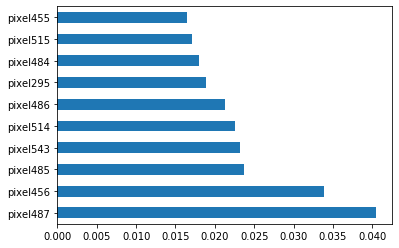

In [6]:
model = ExtraTreesClassifier()
model.fit(X, y)
feat_importances = pd.Series(model.feature_importances_, index=df.iloc[:,1:].columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [25]:
Corr=[]
for i in X:
    l=i.reshape(28, 28)
    tmp_corr=[]
    for j in range(4):
        for k in range(4):
            tmp_corr.append(l[j*7,k*7])
    Corr.append(tmp_corr)        
coll_names=['pixel'+str(j*49+1) for j in range(len(Corr[0]))]
Corr_df=pd.DataFrame(np.array(Corr),
                   columns=coll_names)
Corr_df.describe(include='all')

,pixel1,pixel50,pixel99,pixel148,pixel197,pixel246,pixel295,pixel344,pixel393,pixel442,pixel491,pixel540,pixel589,pixel638,pixel687,pixel736
count,42000.0,42000.0,42000.000000,42000.0,42000.0,42000.000000,42000.000000,42000.000000,42000.0,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000,42000.000000
mean,0.0,0.0,0.005143,0.0,0.0,22.355405,133.590810,46.209238,0.0,50.570143,130.140143,39.244643,0.000762,51.388048,132.981738,16.233929
std,0.0,0.0,1.053972,0.0,0.0,63.716654,110.569713,87.363451,0.0,91.738578,113.850143,82.799118,0.156144,92.575624,110.580711,54.710036
min,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0,0.000000,0.0,0.0,0.000000,152.000000,0.000000,0.0,0.000000,144.000000,0.000000,0.000000,0.000000,151.000000,0.000000
75%,0.0,0.0,0.000000,0.0,0.0,0.000000,253.000000,31.000000,0.0,48.000000,253.000000,0.000000,0.000000,50.000000,253.000000,0.000000
max,0.0,0.0,216.000000,0.0,0.0,255.000000,255.000000,255.000000,0.0,255.000000,255.000000,255.000000,32.000000,255.000000,255.000000,255.000000


# Correlation between features and target variable

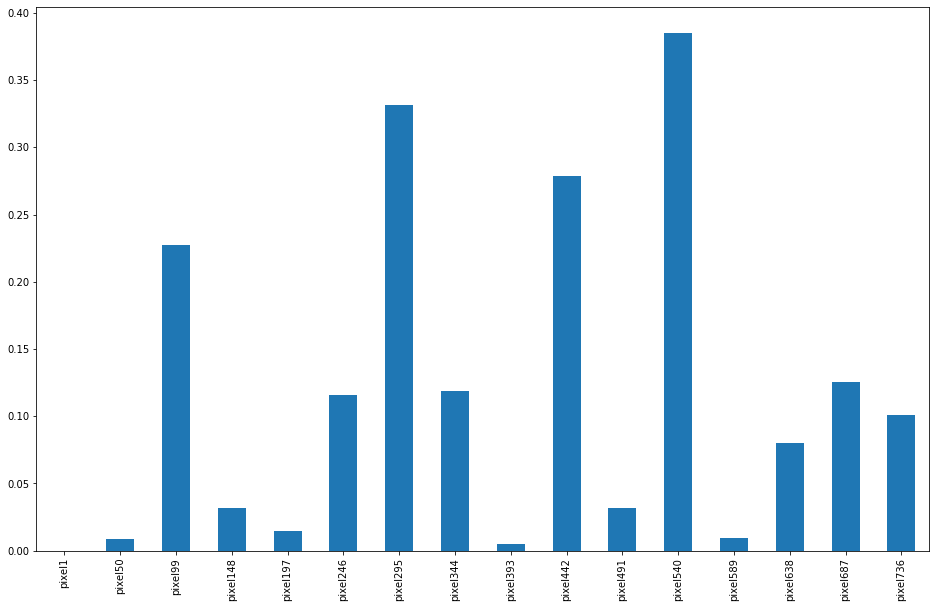

In [52]:
corr=df[coll_names].corrwith(df['label']).fillna(0)
plt.figure(figsize=(16,10))
ax = corr.abs().plot.bar(x='lab', y='val', rot=90)

# Correlation between features

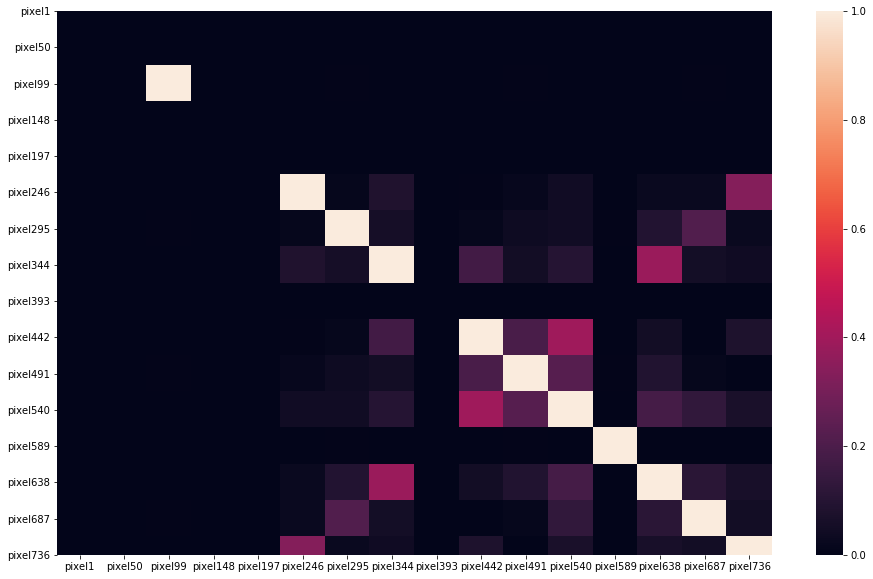

In [47]:
corr=Corr_df.corr().fillna(0)
plt.figure(figsize=(16,10))
sns.heatmap(corr.abs())
plt.show()

# Scatter plots

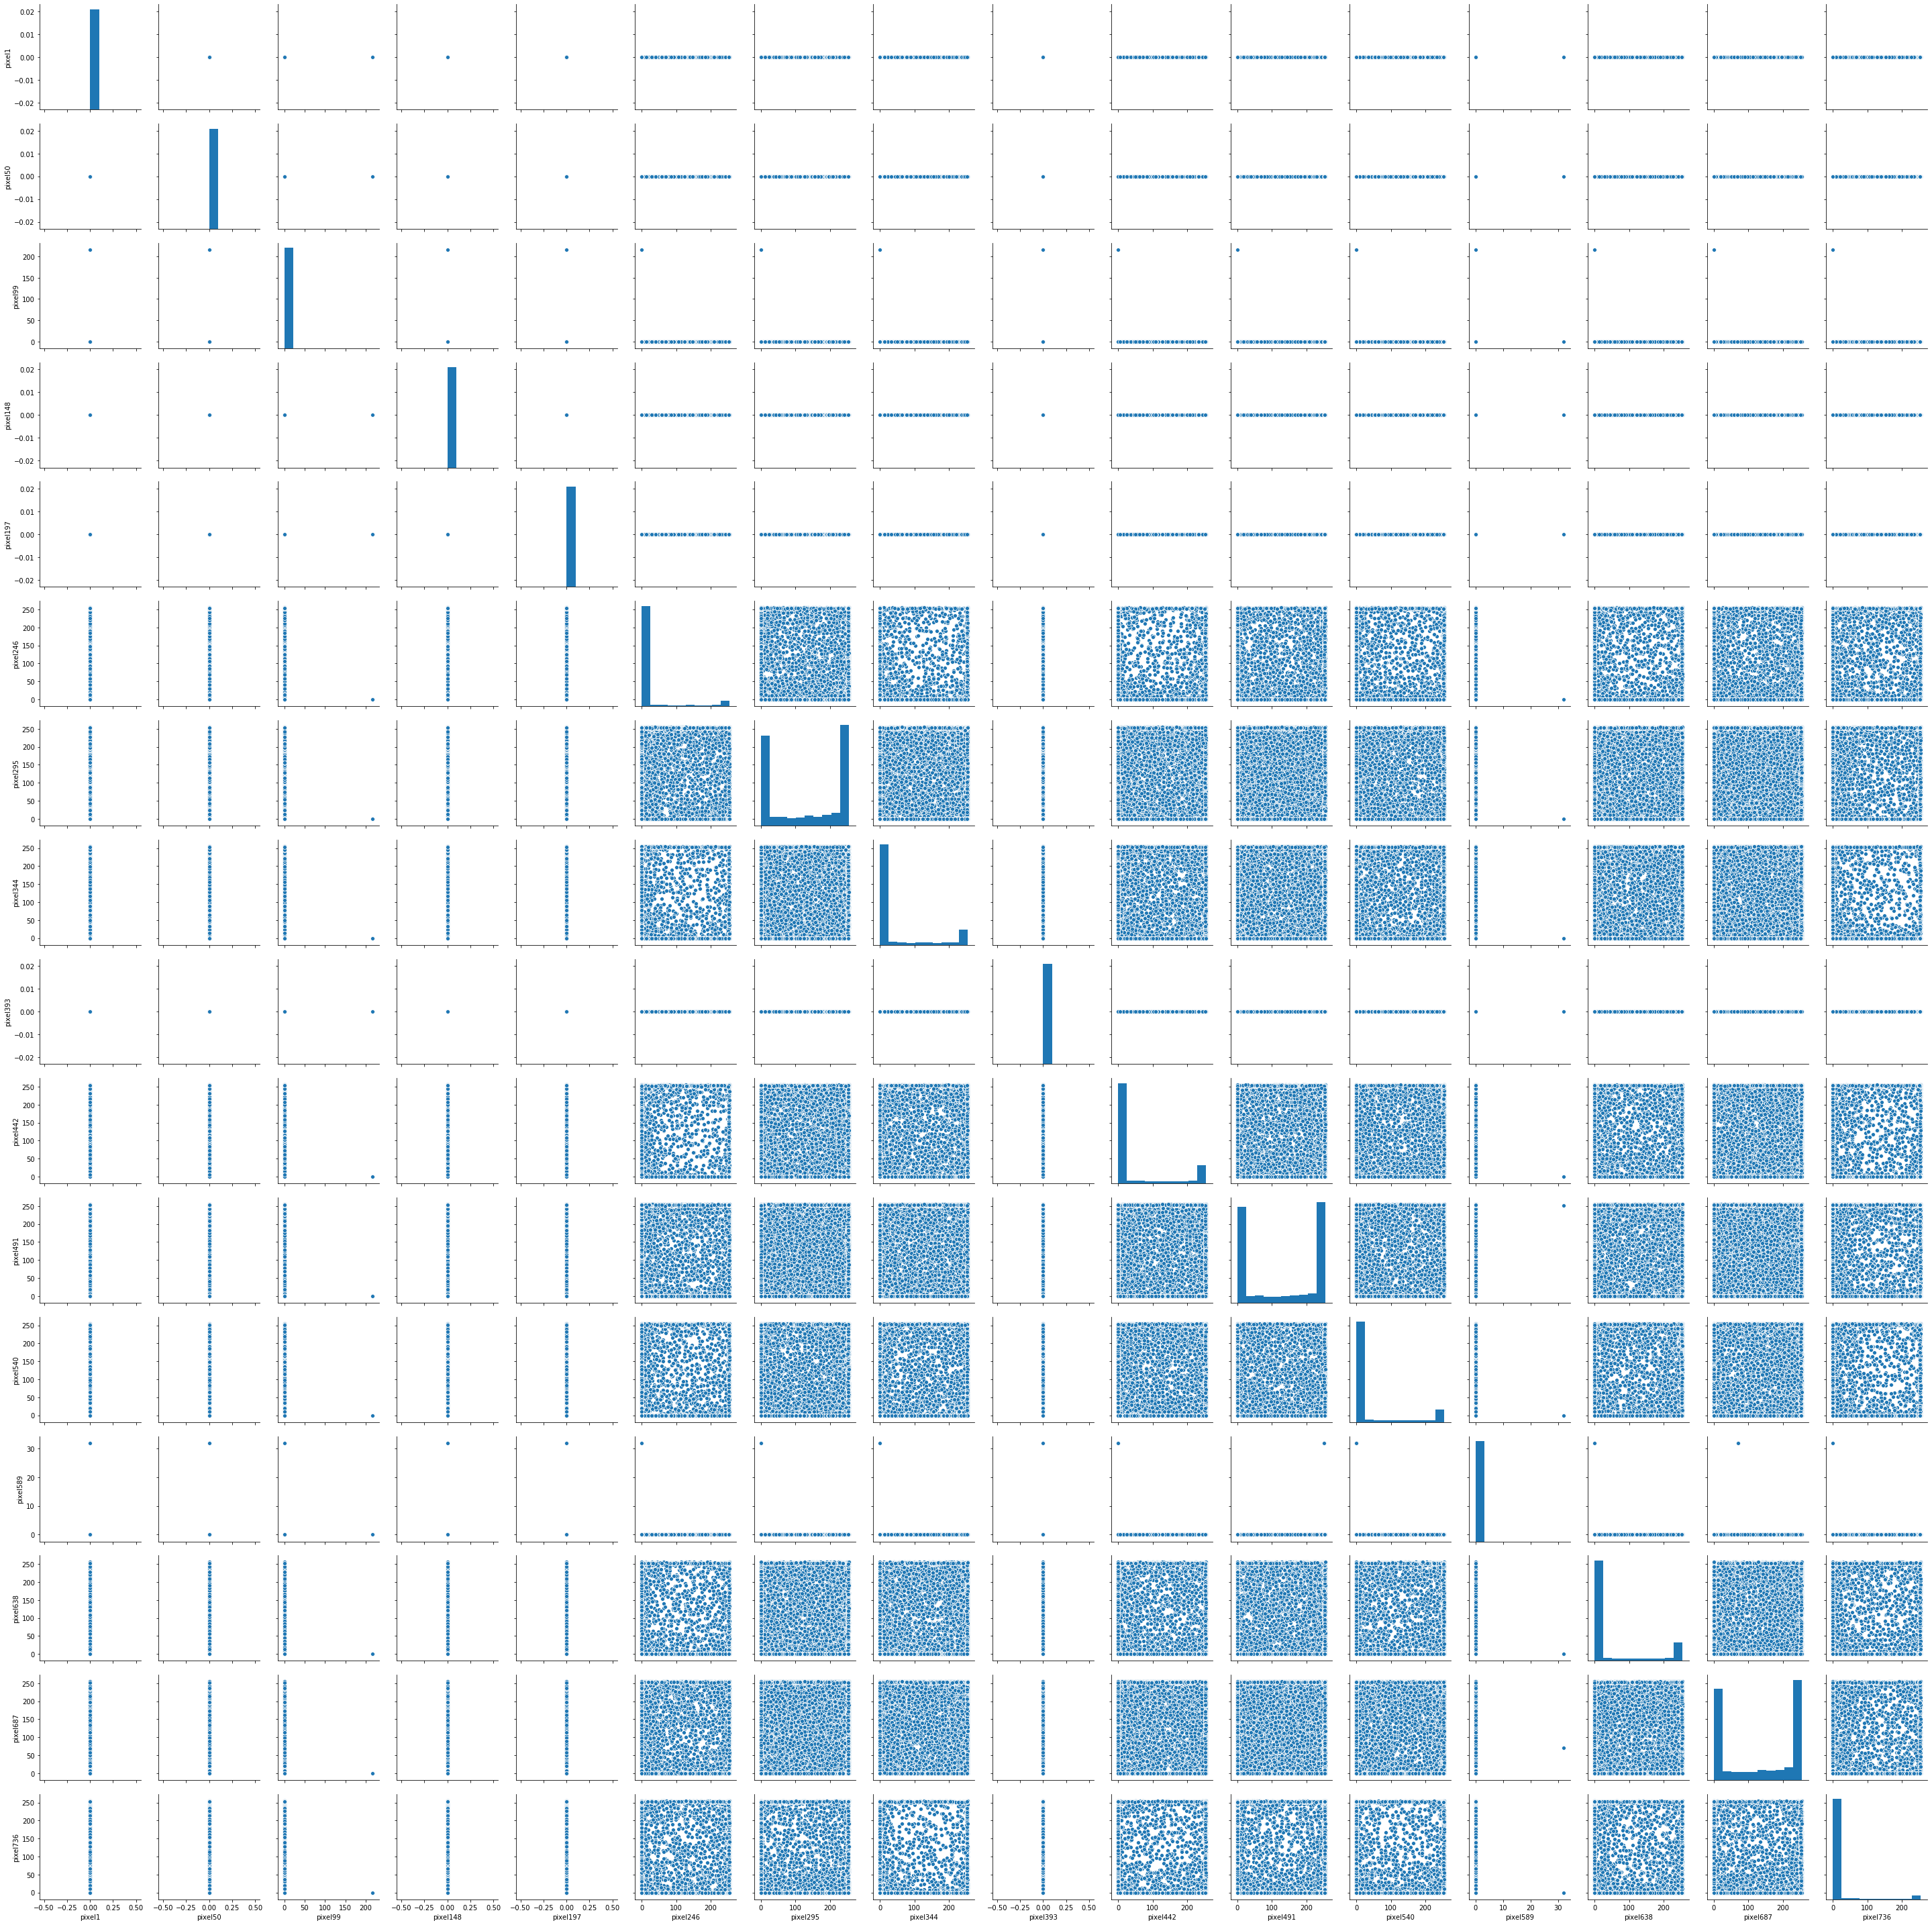

In [9]:
sns.pairplot(Corr_df, vars=Corr_df.columns)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
np.shape(X_train)


(33600, 784)

In [12]:
np.shape(y_train)

(33600,)

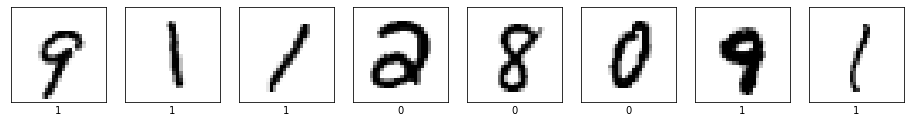

In [13]:
plot_data(X_train,y_train)

In [14]:
cls = MLPClassifier(activation='logistic', max_iter=1000)

In [15]:
cls = cls.fit(X_train, y_train)

In [16]:
y_train_pred = cls.predict(X_train)
accuracy_tr = accuracy_score(y_train, y_train_pred)
precision_tr = precision_score(y_train, y_train_pred)
recall_tr = recall_score(y_train, y_train_pred)
print('Custom Logistic Regression (Train)')
print('Accuracy       : ', accuracy_tr)
print('Precision      : ', precision_tr)
print('Recall         : ', recall_tr)

Custom Logistic Regression (Train)
Accuracy       :  0.9800297619047619
Precision      :  0.9808040142365365
Recall         :  0.9800606343283582


In [17]:
y_test_pred = cls.predict(X_test)
accuracy_ts = accuracy_score(y_test, y_test_pred)
precision_ts = precision_score(y_test, y_test_pred)
recall_ts = recall_score(y_test, y_test_pred)
print('Custom Logistic Regression (Test)')
print('Accuracy       : ', accuracy_tr)
print('Precision      : ', precision_tr)
print('Recall         : ', recall_tr)

Custom Logistic Regression (Test)
Accuracy       :  0.9800297619047619
Precision      :  0.9808040142365365
Recall         :  0.9800606343283582


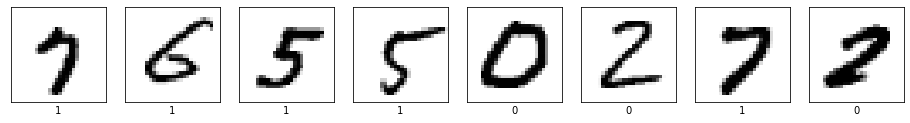

In [18]:
plot_data(X_test,y_test_pred)

# Castom classificator

In [19]:
clsC = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 1000,num_node=[392,28,],accuracy=0.001)
print(np.isinf(X).any())

False


0-th iteration: 19.435318485256623
10-th iteration: 19.130189588664717
20-th iteration: 18.32329668301701
30-th iteration: 16.472648673681025
40-th iteration: 12.96052293946174
50-th iteration: 11.462404093049665
60-th iteration: 10.773737667823482
70-th iteration: 10.122073065427685
80-th iteration: 9.630590204410122
90-th iteration: 9.097697756237535
100-th iteration: 8.629333736608187
110-th iteration: 8.175858058500225
120-th iteration: 7.716732872643761
130-th iteration: 7.260603708000256
140-th iteration: 6.8174867844196045


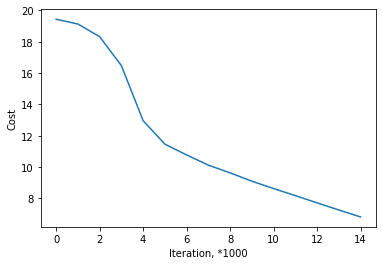

In [20]:
clsC.fit(X_train, y_train.reshape((y_train.shape[0], 1)))

In [21]:
y_train_predC = clsC.predict(X_train)
accuracy_tr = accuracy_score(y_train, y_train_predC)
precision_tr = precision_score(y_train, y_train_predC)
recall_tr = recall_score(y_train, y_train_predC)
print('Custom Logistic Regression (Train)')
print('Accuracy       : ', accuracy_tr)
print('Precision      : ', precision_tr)
print('Recall         : ', recall_tr)

Custom Logistic Regression (Train)
Accuracy       :  0.9192559523809524
Precision      :  0.9022677884883268
Recall         :  0.9440881529850746


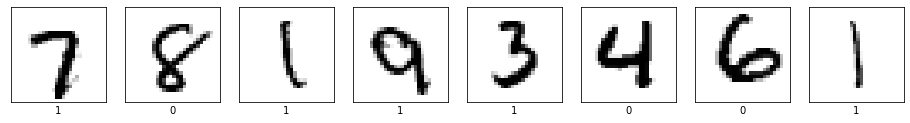

In [26]:
plot_data(X_train,y_train_predC)

In [23]:
y_test_predC = clsC.predict(X_test)
accuracy_ts = accuracy_score(y_test, y_test_predC)
precision_ts = precision_score(y_test, y_test_predC)
recall_ts = recall_score(y_test, y_test_predC)
print('Custom Logistic Regression (Test)')
print('Accuracy       : ', accuracy_tr)
print('Precision      : ', precision_tr)
print('Recall         : ', recall_tr)

Custom Logistic Regression (Test)
Accuracy       :  0.9192559523809524
Precision      :  0.9022677884883268
Recall         :  0.9440881529850746


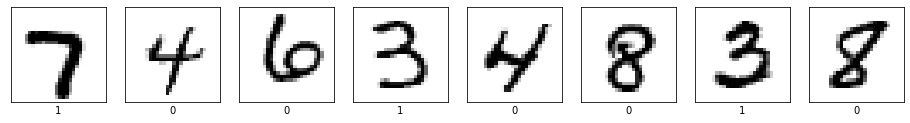

In [24]:
plot_data(X_test,y_test_predC)